In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint


In [2]:
# 1. Define paths for dataset
train_data_dir = r"C:\Users\vidit\OneDrive\Desktop\X_Ray\x-ray\ImagesOriginalSize"

# 2. Image Preprocessing and Data Augmentation
image_size = (224, 224)

In [3]:
# Create an ImageDataGenerator instance for rescaling images and augmenting the data
train_datagen = ImageDataGenerator(
    rescale=1./255,    # Rescale pixel values to [0, 1]
    shear_range=0.2,   # Shear transformation
    zoom_range=0.2,    # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    validation_split=0.2   # Split 20% of the data for validation
)

# 3. Load the Data: Training and Validation sets (use color_mode='grayscale')
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    color_mode='grayscale',  # Use grayscale images
    class_mode='categorical',
    subset='training'  # Set for training
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    color_mode='grayscale',  # Use grayscale images
    class_mode='categorical',
    subset='validation'  # Set for validation
)


Found 343 images belonging to 3 classes.
Found 84 images belonging to 3 classes.


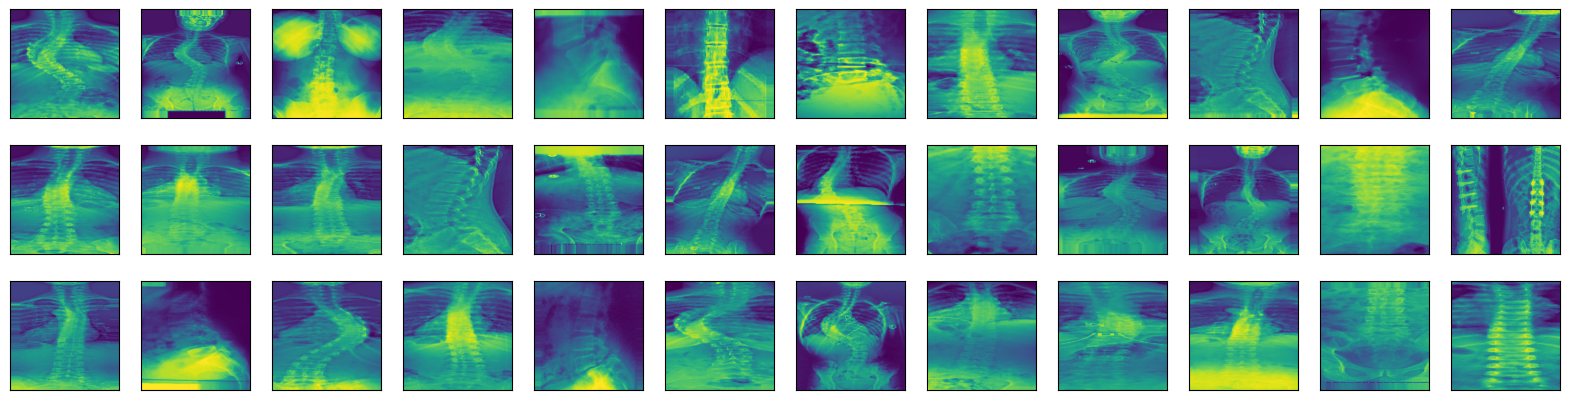

In [4]:
# Display some training images
def plot_sample_images(generator):
    fig = plt.figure(figsize=(20, 5))
    for i in range(36):
        ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
        img, label = generator.next()
        ax.imshow(np.squeeze(img[0]))

plot_sample_images(train_generator)

In [5]:
# 4. Define the Model Architecture (Reduced Complexity)
model = Sequential()

# 1st Convolutional Block (reduced filters)
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 1)))  # Grayscale input
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional Block
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolutional Block (reduced filters)
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  # Slightly reduced dropout

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))  # Reduced dense layer size
model.add(Dropout(0.4))  # Keeping dropout for regularization
model.add(Dense(3, activation='softmax'))  # 3 classes: Normal, Scoliosis, Spondylolisthesis
# Model Summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [6]:
# 5. Compile the Model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [7]:
# 6. Define Model Checkpoints to Save the Best Model
checkpointer = ModelCheckpoint(filepath='vertebrae_xray_model_best.hdf5', verbose=1, save_best_only=True)


In [8]:
# 7. Train the Model
epochs = 25
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Automatically adjusts to the batch size
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs,
    callbacks=[checkpointer],
    verbose=2
)

Epoch 1/25

Epoch 1: val_loss improved from inf to 1.04034, saving model to vertebrae_xray_model_best.hdf5
11/11 - 31s - loss: 1.2526 - accuracy: 0.3469 - val_loss: 1.0403 - val_accuracy: 0.4405 - 31s/epoch - 3s/step
Epoch 2/25

Epoch 2: val_loss improved from 1.04034 to 0.93614, saving model to vertebrae_xray_model_best.hdf5
11/11 - 11s - loss: 1.0355 - accuracy: 0.4636 - val_loss: 0.9361 - val_accuracy: 0.5476 - 11s/epoch - 1s/step
Epoch 3/25

Epoch 3: val_loss improved from 0.93614 to 0.82103, saving model to vertebrae_xray_model_best.hdf5
11/11 - 12s - loss: 0.9133 - accuracy: 0.6035 - val_loss: 0.8210 - val_accuracy: 0.5238 - 12s/epoch - 1s/step
Epoch 4/25

Epoch 4: val_loss improved from 0.82103 to 0.64415, saving model to vertebrae_xray_model_best.hdf5
11/11 - 11s - loss: 0.7951 - accuracy: 0.6764 - val_loss: 0.6442 - val_accuracy: 0.7500 - 11s/epoch - 1s/step
Epoch 5/25

Epoch 5: val_loss improved from 0.64415 to 0.58242, saving model to vertebrae_xray_model_best.hdf5
11/11 - 1

In [9]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Physical devices cannot be modified after being initialized


In [10]:
# 8. Load the Best Model
from keras.models import load_model

# Load the model that gave the best validation accuracy
model = load_model('vertebrae_xray_model_best.hdf5')

In [11]:
# 9. Visualize Predictions on the Test Set
def visualize_predictions(model, generator, class_names, batch_size=8):
    # Get a batch of images and labels from the generator
    x_batch, y_batch_true = generator.next()  # Get next batch of images from the generator
    
    # Make predictions
    y_batch_pred = model.predict(x_batch)  # Predict on the batch
    y_batch_pred_classes = np.argmax(y_batch_pred, axis=1)  # Get predicted class indices
    y_batch_true_classes = np.argmax(y_batch_true, axis=1)  # Get true class indices
    
    # Plot the first few images along with predicted and true labels
    plt.figure(figsize=(12, 12))
    for i in range(batch_size):
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.squeeze(x_batch[i]), cmap='gray')  # Use np.squeeze to remove single-dimensional entries
        plt.title(f"True: {class_names[y_batch_true_classes[i]]}, Pred: {class_names[y_batch_pred_classes[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 268ms/step


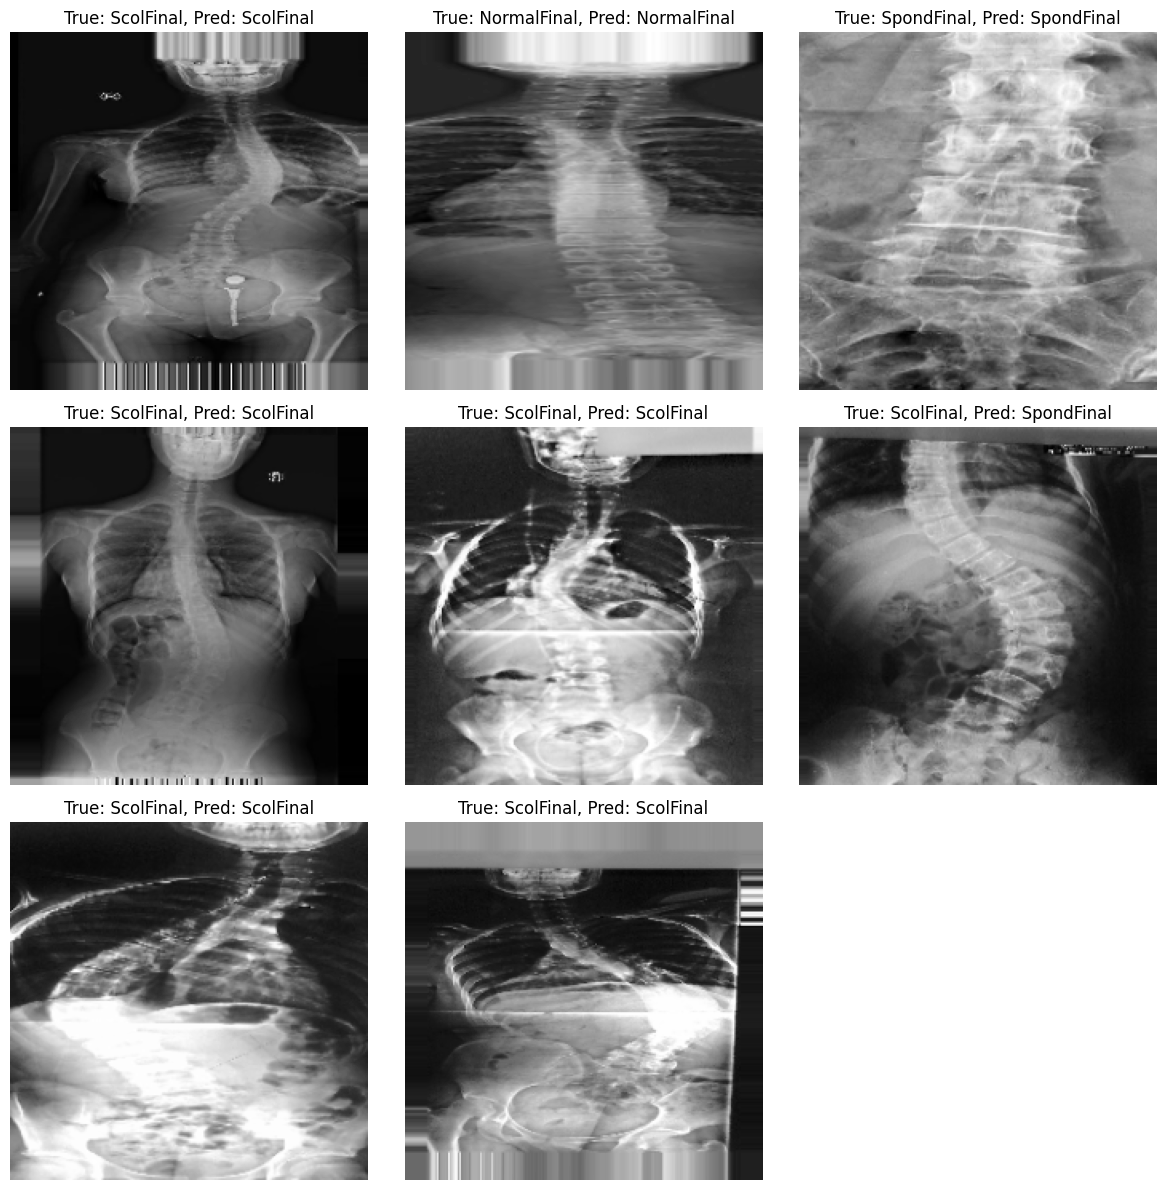

In [12]:
# Get the class indices from the generator and reverse it to get the label names
class_names = {v: k for k, v in train_generator.class_indices.items()}

# Visualize Predictions on Validation Set
visualize_predictions(model, validation_generator, class_names)

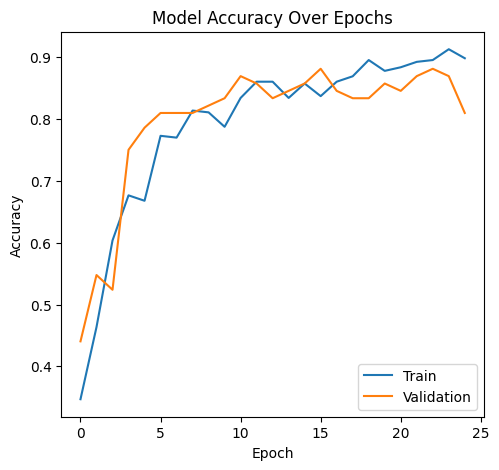

In [13]:
# 10. Plot Training and Validation Accuracy and Loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

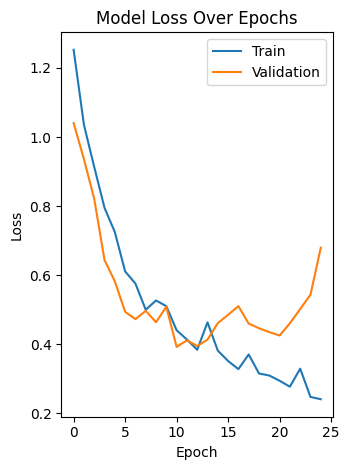

In [14]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [15]:
# 11. Compute Confusion Matrix and Classification Report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Ensure the validation generator is not shuffled
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Important for consistent predictions
)

Found 84 images belonging to 3 classes.


In [16]:
# Get the number of samples
nb_samples = len(validation_generator.filenames)
batch_size = validation_generator.batch_size

# Get the predictions
Y_pred = model.predict(validation_generator, steps=np.ceil(nb_samples / batch_size))
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels
y_true = validation_generator.classes

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Print classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=class_labels))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)


3/3 [==============================] - 2s 557ms/step
Classification Report
              precision    recall  f1-score   support

 NormalFinal       0.83      0.83      0.83        24
   ScolFinal       0.85      0.92      0.88        37
  SpondFinal       1.00      0.87      0.93        23

    accuracy                           0.88        84
   macro avg       0.89      0.87      0.88        84
weighted avg       0.89      0.88      0.88        84



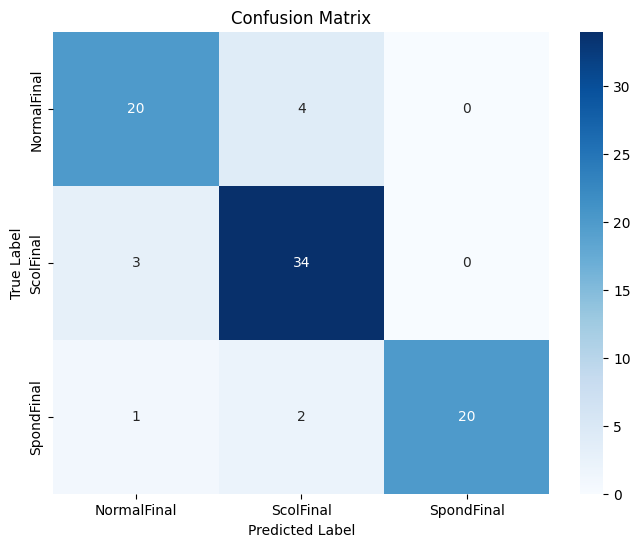

In [17]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()